In [1]:
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf

TEST_SIZE=0.1
SEED=1
BATCH_SIZE=64

tf.random.set_seed(SEED)


https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification/data?select=traffic_Data

In [2]:
labels_df = pd.read_csv('C:/Users/JP/Desktop/Traffic sign detection using deep learning/UpConstruction/model/labels.csv')
print(labels_df.sample(10))

#Create a label map
label_map = dict(labels_df.values)

    ClassId                          Name
13       13                 Dont Go Right
21       21                   Go straight
39       39  Dangerous curve to the right
23       23              Go Left or right
35       35                Zebra Crossing
2         2          Speed limit (30km/h)
28       28            watch out for cars
30       30             Bicycles crossing
32       32                  Road Divider
7         7          speed limit (80km/h)


In [3]:
image_list = list(Path('C:/Users/JP/Desktop/Traffic sign detection using deep learning/UpConstruction/model/traffic_Data/DATA').glob(r'**/*.png'))
labels = list(map(lambda path: os.path.split(os.path.split(path)[0])[1], image_list))

#Create dataframe with path of images and labels
image_series = pd.Series(image_list).astype(str)
labels_series = pd.Series(labels).astype(str)
frame = {'image':image_series, 'label':labels_series}
image_df = pd.DataFrame(frame)
image_df.info()
print(image_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4170 entries, 0 to 4169
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4170 non-null   object
 1   label   4170 non-null   object
dtypes: object(2)
memory usage: 65.3+ KB
                                                  image label
245   C:\Users\JP\Desktop\Traffic sign detection usi...    11
2237  C:\Users\JP\Desktop\Traffic sign detection usi...    31
60    C:\Users\JP\Desktop\Traffic sign detection usi...     0
1668  C:\Users\JP\Desktop\Traffic sign detection usi...    28
3227  C:\Users\JP\Desktop\Traffic sign detection usi...    50


<Axes: xlabel='label', ylabel='count images'>

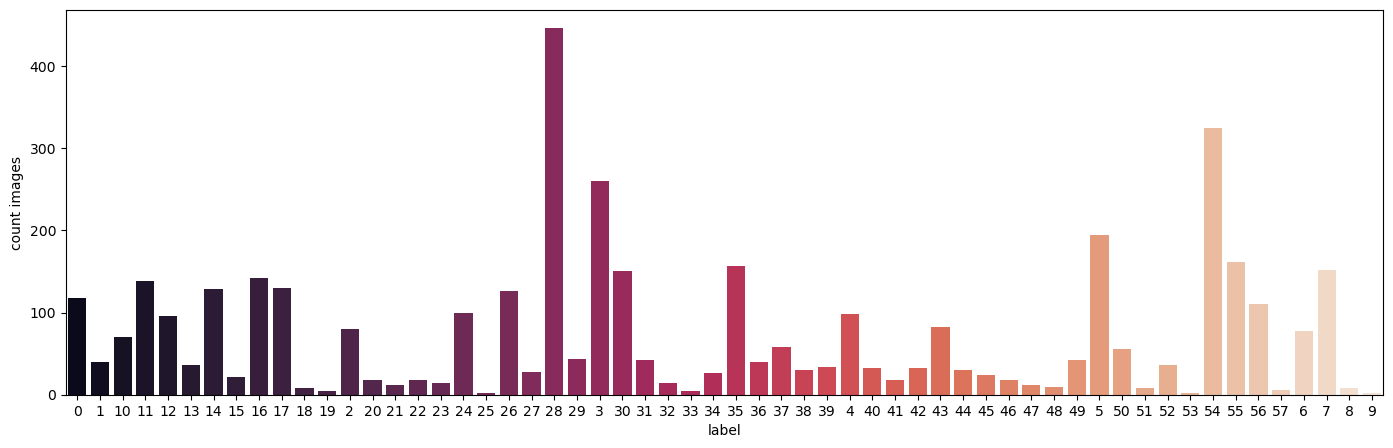

In [4]:
count_labels = image_df.groupby(['label']).size()
plt.figure(figsize=(17,5))
plt.ylabel('count images')
sns.barplot(x=count_labels.index, y=count_labels, palette="rocket")

In [5]:
SPLIT_MINIMUM_COUNT = 1

In [6]:
def split_dataset(df, rate=SPLIT_MINIMUM_COUNT):
 

  count_labels = df.groupby(['label']).size()
  count_labels_df = count_labels.to_frame(name='count_images').reset_index()

  drop_label_list = list(
      count_labels_df['label'].\
      loc[count_labels_df['count_images']<SPLIT_MINIMUM_COUNT]
  )

  drop_df = df.copy()
  split_df = df.copy()

  for index, row in df.iterrows():
    if str(row.label) in drop_label_list:
      split_df = split_df.drop(index)
    else:
      drop_df = drop_df.drop(index)

  return split_df, drop_df

def custom_train_test_split(df):
    
  
    labels = df.label.unique()
    test_df = pd.DataFrame()

    for label in labels:
      label_samples = df.loc[df.label==label]
      test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,
                               random_state=SEED))
    
    train_df = df.drop(list(test_df.index), axis=0)
    test_df = test_df.sample(frac=1, random_state=SEED)
    train_df = train_df.sample(frac=1, random_state=SEED)

    return train_df, test_df


In [7]:
split_df, _ = split_dataset(image_df)
train_df, test_df = custom_train_test_split(split_df)
train, val = custom_train_test_split(train_df)


C:\Users\JP\AppData\Local\Temp\ipykernel_10372\3263403654.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,
C:\Users\JP\AppData\Local\Temp\ipykernel_10372\3263403654.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,
C:\Users\JP\AppData\Local\Temp\ipykernel_10372\3263403654.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(label_samples.sample(len(label_samples)//10+1,
C:\Users\JP\AppData\Local\Temp\ipykernel_10372\3263403654.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [8]:
train_labels = train_df.groupby(['label']).size()
train_labels.shape
NUM_CLASSES = len(train_labels)
print(NUM_CLASSES)


58


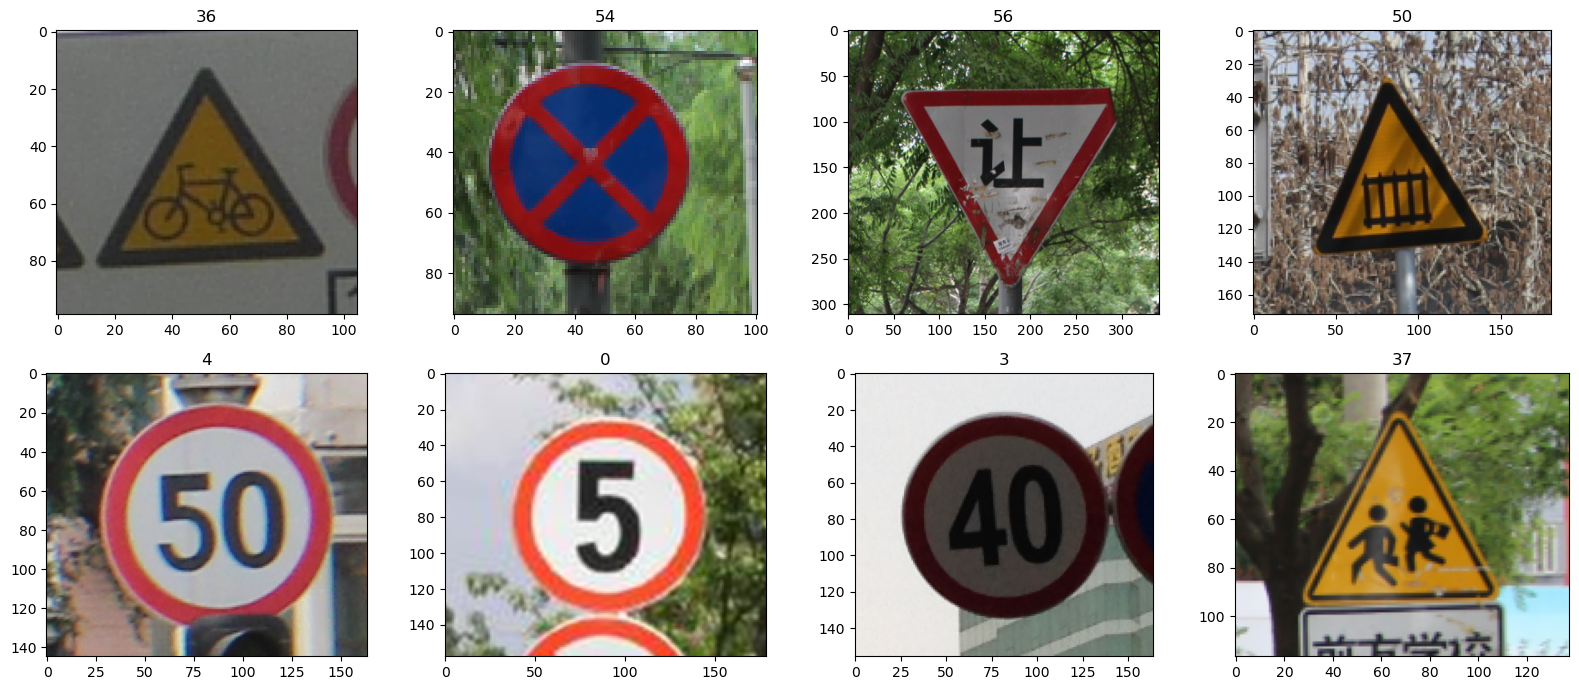

In [9]:
#plot images
fig, axes = plt.subplots(2,4, figsize=(16, 7))
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.image.iloc[idx]))
    ax.set_title(train_df.label.iloc[idx])
plt.tight_layout()
plt.show()

Parth 2. Train model

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rotation_range = 10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='constant',
    shear_range=0.1,
    zoom_range=0.2,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_images = test_generator.flow_from_dataframe(
    dataframe=val,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
)


Found 3718 validated image filenames belonging to 58 classes.
Found 405 validated image filenames belonging to 58 classes.
Found 452 validated image filenames belonging to 58 classes.


In [12]:
#create model
def create_model(input_shape=(128,128,3)):
  
  inputs = tf.keras.layers.Input(input_shape)

  base_model = tf.keras.applications.MobileNet(
      include_top=False,
      weights='imagenet',
      pooling='avg'
  )
  base_model.trainable = False
  
  x = base_model(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  #x = tf.keras.layers.Dense(256, activation='relu')(x)
  outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return tf.keras.models.Model(inputs, outputs)

In [13]:
model = create_model()

In [14]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_images,
    epochs=10,
    validation_data=val_images,
    callbacks=[callback]
)

Epoch 1/10
59/59 [==============================] - 22s 345ms/step - loss: 0.9639 - acc: 0.7469 - val_loss: 0.4785 - val_acc: 0.8593
Epoch 2/10
59/59 [==============================] - 21s 347ms/step - loss: 0.2087 - acc: 0.9346 - val_loss: 0.1815 - val_acc: 0.9407
Epoch 3/10
59/59 [==============================] - 21s 350ms/step - loss: 0.1397 - acc: 0.9548 - val_loss: 0.0962 - val_acc: 0.9704
Epoch 4/10
59/59 [==============================] - 20s 346ms/step - loss: 0.0952 - acc: 0.9683 - val_loss: 0.0715 - val_acc: 0.9778
Epoch 5/10
59/59 [==============================] - 21s 349ms/step - loss: 0.0819 - acc: 0.9731 - val_loss: 0.0990 - val_acc: 0.9753
Epoch 6/10
59/59 [==============================] - 21s 349ms/step - loss: 0.0835 - acc: 0.9731 - val_loss: 0.0685 - val_acc: 0.9728
Epoch 7/10
59/59 [==============================] - 21s 350ms/step - loss: 0.0689 - acc: 0.9755 - val_loss: 0.0524 - val_acc: 0.9852
Epoch 8/10
59/59 [==============================] - 21s 353ms/step - 

In [16]:
model.save('Trafffic_sign.h5')

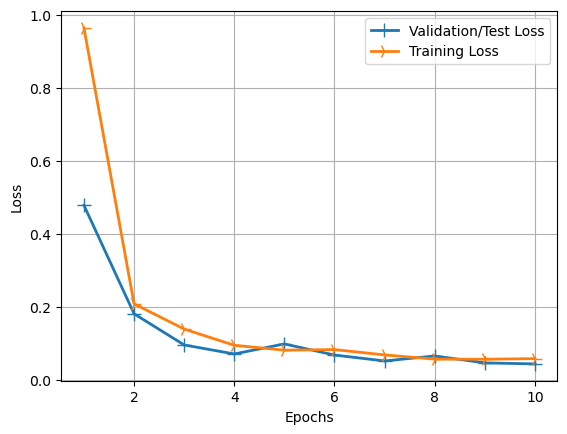

In [17]:

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

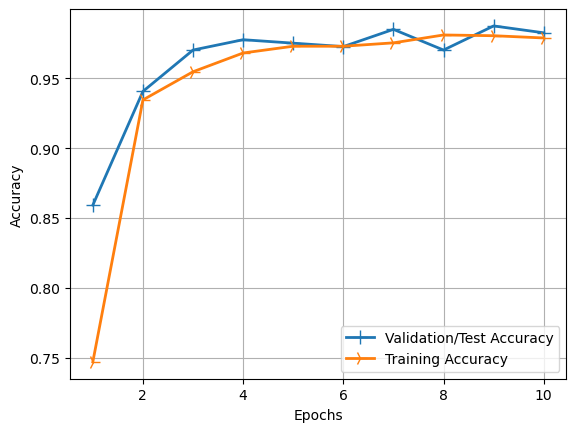

In [18]:
history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
import numpy as np

In [20]:
y=np.concatenate([val_images.next()[1] for i in range(val_images.__len__())])
true_labels=np.argmax(y, axis=-1)
prediction= model.predict(val_images, verbose=2)
prediction=np.argmax(prediction, axis=-1)

7/7 - 2s - 2s/epoch - 217ms/step


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=true_labels, y_pred=prediction)

Confusion matrix, without normalization
[[11  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]
Accuracy: 0.983
Precision: 1.000
Recall: 0.983
F-Measure: 0.983


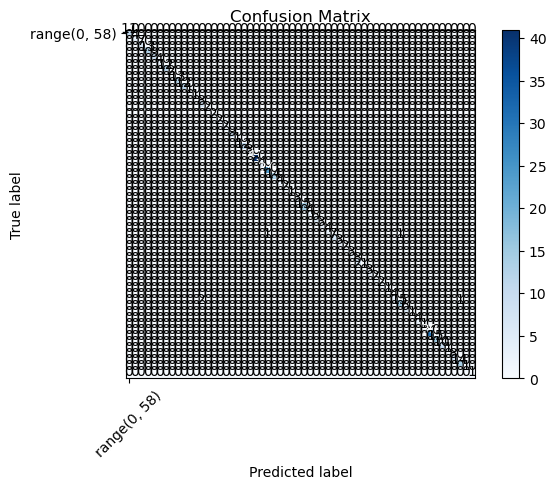

In [23]:
plot_confusion_matrix(cm=cm, classes=[range(58)], title='Confusion Matrix')
from sklearn.metrics import accuracy_score
acc=accuracy_score(true_labels,prediction) 
print('Accuracy: %.3f' % acc)
from sklearn.metrics import precision_score
precision = precision_score(true_labels,prediction,labels=[1,2], average='micro')
print('Precision: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(true_labels,prediction, average='micro')
print('Recall: %.3f' % recall)
from sklearn.metrics import f1_score
score = f1_score(true_labels,prediction, average='micro')
print('F-Measure: %.3f' % score)